In [ ]:
#colab specific...else ensure content is in dir!
#!unzip inventions.zip
#!unzip /content/wtc-1.zip
#!unzip /content/wtc-2.zip
#!unzip /content/wtc-fugues.zip
!unzip /content/deutschl.zip

In [ ]:
!pip install music21
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb
!pip install pygame

In [1]:
import os
from typing import Optional
import music21 as m21
from music21 import *
import pygame 

us = environment.UserSettings()
us['musescoreDirectPNGPath'] = '/usr/bin/mscore'
us['directoryScratch'] = '/tmp'

pygame 2.1.2 (SDL 2.0.16, Python 3.7.14)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
#user must fetch these two params prior to instantiation
KERN_DATASET_PATH = "/content/essen/europa/deutschl/test"
SAVE_DIR = "/content/dataset"

class ScoreLibrarian:

  '''inspired by the role of Church Music Librarian in a music ministry. Handles keeping of 
     scores, score retrieval, making copies, and the PREPROCESSING actions that are required
     for the child class to interperet(the model). in this case, the scorelibrarian is the 
     preprocessor, and the "singer" or "musician" is the model that learns the music. The musician
     recieves the score "ready 2 go" without the need of preprocessing actions so that they can 
     focus soley on learning the music'''

  '''you must specify the dataset_path, the save dir path, and if you pass auto_encode in fetch
     then will write a file in dir of a list that is encoded song'''

  def __init__(self, dataset_path:str, save_dir:str):
    '''score librarian will load the data from selected dirs and "fetch" scores'''
    self._acceptable_durations = [0.25, 0.5, 0.75, 1, 1.5, 2, 3, 4]
    self.dataset_path = dataset_path
    self.save_dir = save_dir 
    #create save dir upon instantiation!
    if not os.path.exists(self.save_dir):
      os.mkdir(save_dir)
    print("Loading Songs...\n")
    self.songs = self.__getitem__()
    print(f"\033[93mLoaded {len(self.songs)} songs from directory!\033[0m\n")
    
    
  def __getitem__(self):
    '''returns all songs from dir'''
    return self._load_songs_in_kern(self.dataset_path, "krn")
    

  def _load_songs_in_kern(self, dataset_path:str, file_type:str, songs=[]):
    for path, subdir, files in os.walk(dataset_path):
      for f in files:
        if f[-3:] == file_type and f not in songs:
          song = m21.converter.parse(os.path.join(path, f))
          songs.append(song)
      return songs 


  def _has_acceptable_duration(self, song):
    for note in song.flat.notesAndRests:
      if note.duration.quarterLength not in self._acceptable_durations:
        return False 
    return True 


  def _transpose(self, song):
    '''transposes song to Cmaj/Amin'''
    #get key from song
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key_sig = measures_part0[0][4]
    #estimate key using music21(if no key provided)
    if not isinstance(key, m21.key.Key):
      key_sig = song.analyze("key")
    print(f"\nOriginal key signature: {key_sig}\n")
    #get interval for transposition
    if key_sig.mode == "major":
      interval = m21.interval.Interval(key_sig.tonic, m21.pitch.Pitch("C"))
    elif key_sig.mode == "minor":
      interval = m21.interval.Interval(key_sig.tonic, m21.pitch.Pitch("A"))
    #transpose on that interval(which is an object)
    return song.transpose(interval)


  def fetch_score(self, song_index:int, 
                  show_song:Optional[bool]=False, 
                  halt_transpostion:Optional[bool]=False,
                  deliver_encoded:Optional[bool]=False):
    '''will fetch a single song based on the index_place that you specify and return
       the transposed(concert pitch) version of the score. Halt_transpostion returns non trans
       song'''
    raw_song = self.songs[song_index]
    print(f"Song #{song_index} fetched from my library!")
    print(f"has acceptable durations: {self._has_acceptable_duration(raw_song)}")
    transposed_song = self._transpose(raw_song)

    def halt_or_not(show_song:bool, halt_transpostion:bool):
      if show_song and not halt_transpostion:
        transposed_song.show()
        transposed_song.show('midi')
      if show_song and halt_transpostion:
        raw_song.show()
        raw_song.show('midi')
      return raw_song if halt_transpostion else transposed_song

    def encode_or_not(encode, fetched_song):
      return self.encode_song(fetched_song) if encode \
             else fetched_song

    fetched_song0 = halt_or_not(show_song, halt_transpostion)
    return encode_or_not(deliver_encoded, fetched_song0)
    

  def encode_song(self, song, time_step=0.25, encoded_song=[]):
    '''convert song to time series representation.time_step is a 16th note'''
    #p=60, d=1.0 -> [60, "_", "_", "_"]
    for event in song.flat.notesAndRests:
      #handle notes 
      if isinstance(event, m21.note.Note):
        symbol = event.pitch.midi
      #handle rests
      elif isinstance(event, m21.note.Rest):
        symbol = "r"
      #convert the note/rest into time series notation
      steps = int(event.duration.quarterLength / time_step)
      for step in range(steps):
        if step == 0:
          encoded_song.append(symbol)
        else:
          encoded_song.append("_")

    #cast encoded song to a str...map is like casting a type!!!
    encoded_song = " ".join(map(str, encoded_song))
    return encoded_song


  def prepare_encoded_library(self):
    '''recursively prepares all scores in dir that is specified upon 
       instantiantion aka dataset_path'''
    for i, song in enumerate(self.songs):
      song = self._transpose(song)
      encoded_song = self.encode_song(song)
      #str that will exist with the instantiation of the class is save dir
      save_path = os.path.join(self.save_dir, str(i))
      if not os.path.exists(save_path):
        with open(save_path, "w") as fp:
          fp.write(encoded_song)


######################END_ScoreLibrarian_CLASS#################################


In [3]:
'''main job execution block'''

def execute():
  librarian = ScoreLibrarian(KERN_DATASET_PATH, SAVE_DIR)
  librarian.prepare_encoded_library()


if __name__ == "__main__":
  execute()



Loading Songs...

Loaded 12 songs from directory!


Original key signature: F major


Original key signature: e minor


Original key signature: a minor


Original key signature: e minor


Original key signature: F major


Original key signature: g minor


Original key signature: F major


Original key signature: a minor


Original key signature: a minor


Original key signature: D major


Original key signature: e minor


Original key signature: e minor



In [ ]:
#load the songs
#filter out the songs with non-acceptable durations
#transpose songs to cmaj/amin
#encode songs with music time series rep
#save songs to text file 

Loading Songs...

Loaded 24 songs from directory!

Song #0 fetched from my library!
has acceptable durations: True

Original key signature: F major



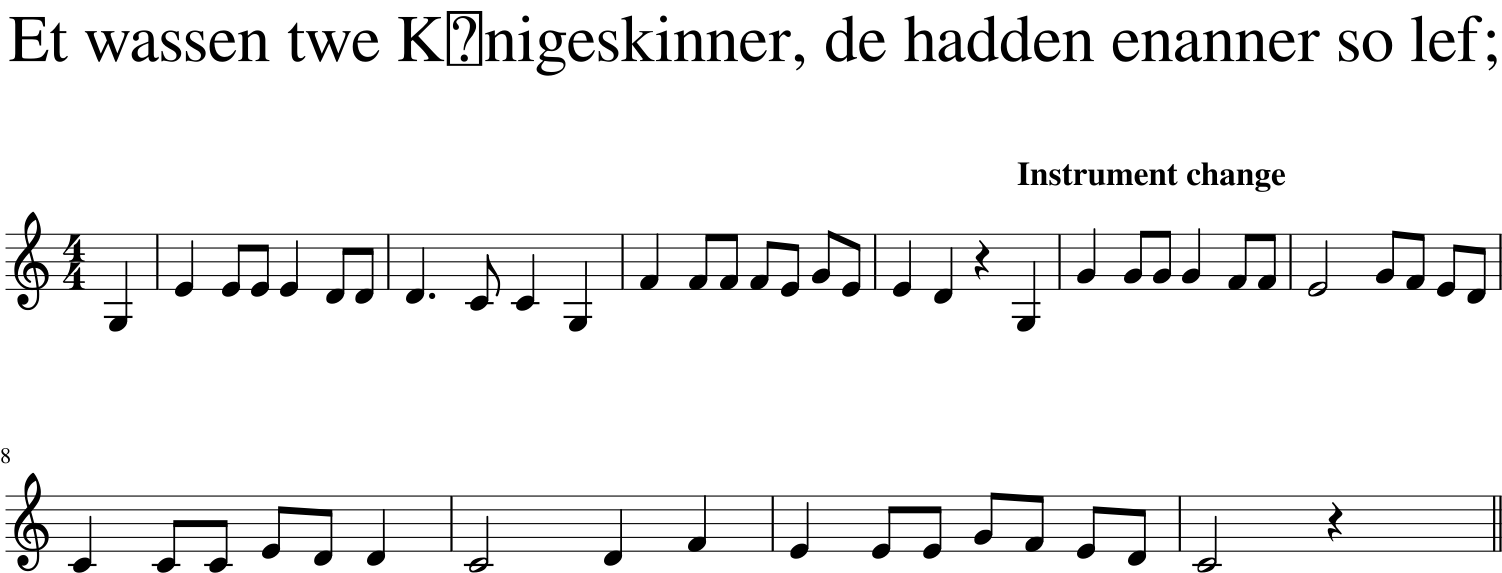

Song #0 fetched from my library!
has acceptable durations: True

Original key signature: F major



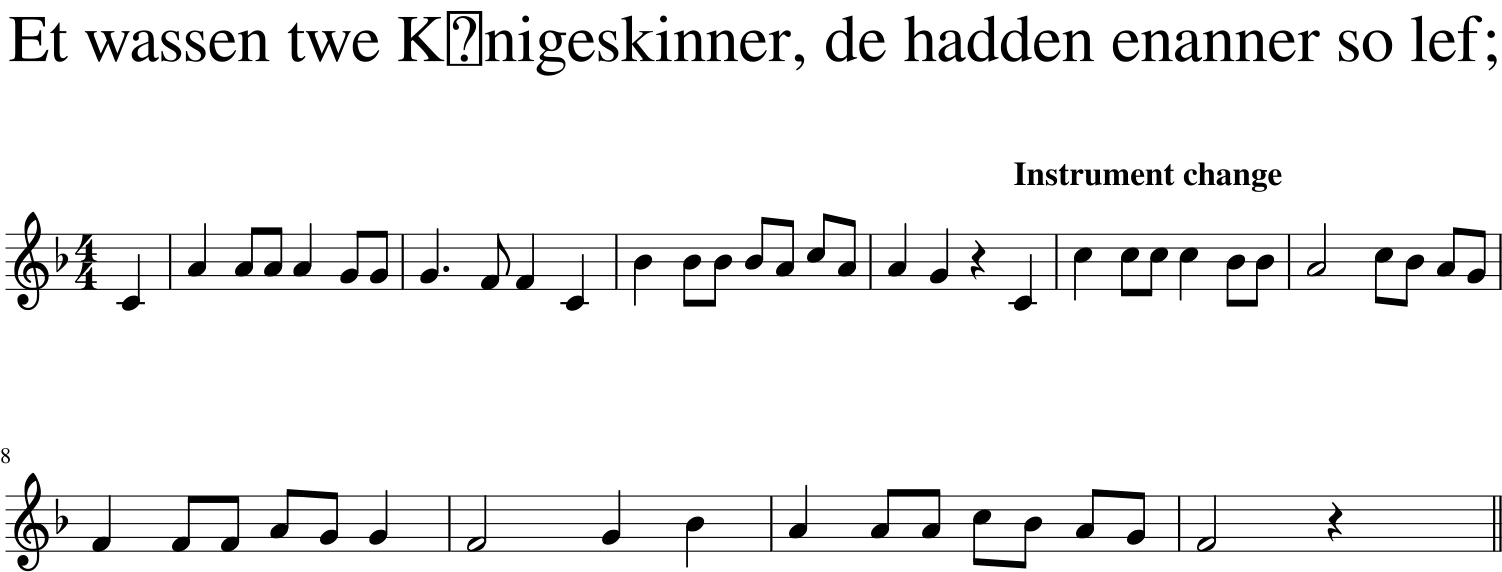

In [4]:
lib = ScoreLibrarian(KERN_DATASET_PATH, SAVE_DIR)

transposed_encoded_song = lib.fetch_score(song_index=0, 
                                                show_song=True, 
                                                deliver_encoded=True)


untransposed_encoded_song = lib.fetch_score(song_index=0, 
                                                  show_song=True, 
                                                  halt_transpostion=True,
                                                  deliver_encoded=True)

